# Necessary import


In [1]:
#pip install spacy
#pip install pyLDAvis
#conda install -c conda-forge spacy-model-en_core_web_md
#conda install -c conda-forge spacy-model-en_core_web_sm

In [1]:
import itertools
import os
import re
import secrets
import string
import numpy as np
import pandas as pd
import spacy
import json
import nltk
import pyLDAvis

import spacy
import tomotopy as tp
from nltk.corpus import stopwords

from itertools import chain

import gensim
from gensim.models.callbacks import CallbackAny2Vec
from gensim.models import Word2Vec, Phrases, KeyedVectors
from gensim.models.phrases import Phraser
from gensim.utils import simple_preprocess

import gensim.corpora as corpora
from gensim.models import CoherenceModel

from nltk.corpus import wordnet
# from pattern.en import pluralize, singularize
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm

from spacy.parts_of_speech import IDS as POS_map


# Partie BERT
from bertopic import BERTopic

# CBOW
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings
from gensim.models import Word2Vec,KeyedVectors
nltk.download('punkt')

from sklearn.cluster import DBSCAN

# For visualization of word2vec model
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

X:\Program\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dana\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Load Data


In [2]:
dataset = pd.read_json("News_Category_Dataset_v2.json", lines=True, dtype={"headline": str})

# Used functions

In [3]:
def dummy_word_split(texts):
    """Function identifying words in a sentence in a really dummy way.
        
        Argument:
            - texts (list of str): a list of raw texts in which we'd like to identify words
            
        Return:
            - list of list containing each word separately.
    """
    texts_out = []
    for text in texts:
        texts_out.append(text.split(" "))
        
    return texts_out

In [4]:
def compute_word_occurences(texts):
    """You have to define this function yourself. """
    
    words = itertools.chain.from_iterable(texts)
    
    word_count = pd.Series(words).value_counts()
    word_count = pd.DataFrame({"Word": word_count.index, "Count": word_count.values})

    return word_count

### Ensuring data quality

In [5]:
def check_data_quality(texts):
    """Check wheter all the dataset is conform to the expected behaviour."""
    assert all([isinstance(t, str) for t in texts]), "Input data contains something different than strings."
    assert all([t != np.nan for t in texts]), "Input data contains NaN values."
    
    return True

In [6]:
def force_format(texts):
    return [str(t) for t in texts]

### Filtering texts

In [7]:
def filter_text(texts_in):
    """Removes incorrect patterns from a list of texts, such as hyperlinks, bullet points and so on"""
    
    texts_out = re.sub(r'https?:\/\/[A-Za-z0-9_.-~\-]*', ' ', texts_in, flags=re.MULTILINE)
    texts_out = re.sub(r'[(){}\[\]<>]', ' ', texts_out, flags=re.MULTILINE)
    texts_out = re.sub(r'&amp;#.*;', ' ', texts_out, flags=re.MULTILINE)
    texts_out = re.sub(r'&gt;', ' ', texts_out, flags=re.MULTILINE)
    texts_out = re.sub(r'â€™', "'", texts_out, flags=re.MULTILINE)
    texts_out = re.sub(r'\s+', ' ', texts_out, flags=re.MULTILINE)
    texts_out = re.sub(r'&#x200B;', ' ', texts_out, flags=re.MULTILINE)
    texts_out = re.sub(r'\-', ' ', texts_out, flags=re.MULTILINE)
    
    # Mail regex
    # This regex is correct but WAY TOO LONG to process. So we skip it with a simpler version
    # texts_out = re.sub(r"(?i)(?:[a-z0-9!#$%&'*+\/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&'*+\/=?^_`{|}~-]+)*|\"(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21\x23-\x5b\x5d-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])*\")@(?:(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\.)+[a-z0-9](?:[a-z0-9-]*[a-z0-9])?|\[(?:(?:(2(5[0-5]|[0-4][0-9])|1[0-9][0-9]|[1-9]?[0-9]))\.){3}(?:(2(5[0-5]|[0-4][0-9])|1[0-9][0-9]|[1-9]?[0-9])|[a-z0-9-]*[a-z0-9]:(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21-\x5a\x53-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])+)\])", '', texts_out, flags=re.MULTILINE)
    texts_out = re.sub(r'[a-zA-Z0-9-_.]+@[a-zA-Z0-9-_.]+\.[a-zA-Z0-9-_.]+', '', texts_out, flags=re.MULTILINE)
    # Phone regex
    # This regex is correct but WAY TOO LONG to process. So we skip it with a simpler version
    # texts_out = re.sub(r".*?(\(?\d{3}\D{0,3}\d{3}\D{0,3}\d{4}).*?", '', texts_out, flags=re.MULTILINE)
    texts_out = re.sub(r"\(?\d{3}\D{0,3}\d{3}\D{0,3}\d{4}", '', texts_out, flags=re.MULTILINE)
    # Remove names in twitter
    texts_out = re.sub(r'@\S+( |\n)', '', texts_out, flags=re.MULTILINE)

    # Remove starts commonly used on social media
    texts_out = re.sub(r'\*', '', texts_out, flags=re.MULTILINE)
    return texts_out

### Unifying texts & converting sentences to list of words

In [8]:
def sent_to_words(sentences):
    """Converts sentences to words.

    Convert sentences in lists of words while removing the accents and the punctuation.

    @param:
        sentences: a list of strings, the sentences we want to convert
    @return
        A list of words' lists.
    """
    for sentence in tqdm(sentences):
        yield (simple_preprocess(str(sentence), deacc=True))

### Removing useless words

In [9]:
#import nltk
#nltk.download('stopwords')

In [10]:
def get_stopwords(additional_stopwords=[]):
    """Return a list of english stopwords, that can be augmented by using a stopwords file or a list of stopwords

    Args:
        filepath (str, optional): path to a text file where each line is a stopword
        additional_stopwords (list of str, optional): list of string representing stopwords
    Returns:
        List of strings representing stopwords
    """
    # Loading standard english stop words
    with open('stopwords.txt', 'r') as f:
        stop_w = f.readlines()
    stopwords = [s.rstrip() for s in stop_w]

    # Adding stop words from sklearn
    stopwords = list(text.ENGLISH_STOP_WORDS.union(stopwords))

    # Adding words from a list if specified
    if additional_stopwords:
        stopwords += additional_stopwords

    # Removing duplicates
    stopwords = list(set(stopwords))

    # Removing some \n that were included in the native stopwords of sklearn ... WHY?
    stopwords = [s.replace("\n", "") for s in stopwords]

    stopwords = sorted(stopwords, key=str.lower)

    return stopwords


### Creating n-grams

In [11]:
def create_bigrams(texts, bigram_count=15, threshold=10, convert_sent_to_words=False, as_str=True):
    """Identify bigrams in texts and return the texts with bigrams integrated"""
    if convert_sent_to_words:
        texts = list(sent_to_words(texts))
    
    bigram_model = Phraser(Phrases(texts, min_count=bigram_count, threshold=threshold))
    
    if as_str:
        return [" ".join(bigram_model[t]) for t in texts]

    else:
        return [bigram_model[t] for t in texts]

def create_trigrams(texts, trigram_count=15, threshold=10, convert_sent_to_words=False, as_str=True):
    """Identify trigrams in texts and return the texts with trigrams integrated"""
    if convert_sent_to_words:
        texts = list(sent_to_words(texts))
    
    bigram_model = Phraser(Phrases(texts, min_count=bigram_count, threshold=threshold))
    
    if as_str:
        return [" ".join(bigram_model[t]) for t in texts]

    else:
        return [bigram_model[t] for t in texts]


### Stemming / Lemmatization & Part-of-Speech filtering

In [12]:
def lemmatize_texts(texts, 
                    allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'], 
                    forbidden_postags=[], 
                    as_sentence=False, 
                    get_postags=False, 
                    spacy_model=None):
    """Lemmatize a list of texts.
    
            Please refer to https://spacy.io/api/annotation for details on the allowed
        POS tags.
        @params:
            - texts_in: a list of texts, where each texts is a string
            - allowed_postags: a list of part of speech tags, in the spacy fashion
            - as_sentence: a boolean indicating whether the output should be a list of sentences instead of a list of word lists
        @return:
            - A list of texts where each entry is a list of words list or a list of sentences
        """
    texts_out = []
    
    if allowed_postags and forbidden_postags:
        raise ValueError("Can't specify both allowed and forbidden postags")

    if forbidden_postags:
        allowed_postags = list(set(POS_map.keys()).difference(set(forbidden_postags)))

    if not spacy_model:
        print("Loading spacy model")
        spacy_model = spacy.load('en_core_web_md')

    print("Beginning lemmatization process")
    total_steps = len(texts)

    docs = spacy_model.pipe(texts)

    for i, doc in tqdm(enumerate(docs), total=total_steps):
        if get_postags:
            texts_out.append(["_".join([token.lemma_, token.pos_]) for token in doc if token.pos_ in allowed_postags])
        else:
            texts_out.append(
                [token.lemma_ for token in doc if token.pos_ in allowed_postags])
    
    if as_sentence:
        texts_out = [" ".join(text) for text in texts_out]
        
    return texts_out


# Analyser le corpus de texte pour en extraire ses caractéristiques spécifiques (taille moyenne, types de mots utilisés, mots les plus fréquents, stopwords, etc.)

1. **Ensuring data quality.** You have to make sure that there's no N/A in your data and that everything is in the good format shape. Having this as the entrance of your pipeline will save you a lot of time in the long run, so try defining it thoroughly.


2. **Filtering texts from unwanted characters**. Especially if you get data from web, you'll end up with HTML tags or encoding stuff that you don't need in your texts. Before applying anything to them, you need to get them cleaned up. Here, try removing the dates and the punctuation for instance.


3. **Unify your texts**. (*This is topic modeling specific*). You don't want to make the difference between a word at the beginning of a phrase of in the middle of it here. You should unify all your words by lowercasing them and deaccenting them as well.


4. **Converting sentences to lists of words**. Some words aren't needed for our analyses, such as *your*, *my*, etc. In order to remove them easily, you have to convert your sentences to lists of words. You can use the dummy function defined above but I'd advised against it. Try finding a function that does that smoothly in [gensim.utils](https://radimrehurek.com/gensim/utils.html)!


5. **Remove useless words**. You need to remove useless words from your corpus. You have two approaches: [use a hard defined list of stopwords](https://www.analyticsvidhya.com/blog/2019/08/how-to-remove-stopwords-text-normalization-nltk-spacy-gensim-python/) or rely on TF-IDF to identify useless words. The first is the simplest, the second might yield better results!


6. **Creating n-grams**. If you look at New York, it is composed of two words. As a result, a word count wouldn't really return a true count for *New York* per se. In NLP, we represent New York as New_York, which is considered a single word. The n-gram creation consists in identifying words that occur together often and regrouping them. It boosts interpretability for topic modeling in this case.


7. **Stemming / Lemmatization**. Shouldn't run, running, runnable be grouped and counted as a single word when we're identifying discussion topics? Yes, they should. Stemming is the process of cutting words to their word root (run- for instance) quite brutally while lemmatization will do the same by identifying the kind of word it is working on. You should convert the corpus words into those truncated representations to have a more realistic word count.


8. **Part of speech tagging**. POS helps in the identification of verbs, nouns, adjectives, etc. For topic models, it is a good idea to work only on verbs and nouns. Adjectives don't convey info about the actual underlying topic discussed at hand.

## Pre-Processing

### Ensuring the data quality

In [13]:
dataset

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26
...,...,...,...,...,...,...
200848,TECH,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,"Reuters, Reuters",https://www.huffingtonpost.com/entry/rim-ceo-t...,Verizon Wireless and AT&T are already promotin...,2012-01-28
200849,SPORTS,Maria Sharapova Stunned By Victoria Azarenka I...,,https://www.huffingtonpost.com/entry/maria-sha...,"Afterward, Azarenka, more effusive with the pr...",2012-01-28
200850,SPORTS,"Giants Over Patriots, Jets Over Colts Among M...",,https://www.huffingtonpost.com/entry/super-bow...,"Leading up to Super Bowl XLVI, the most talked...",2012-01-28
200851,SPORTS,Aldon Smith Arrested: 49ers Linebacker Busted ...,,https://www.huffingtonpost.com/entry/aldon-smi...,CORRECTION: An earlier version of this story i...,2012-01-28


In [14]:
source = force_format(dataset["headline"])
print(f"Is the dataset passing our data quality check?\n{check_data_quality(source)}")

Is the dataset passing our data quality check?
True


In [15]:
source[:10]

['There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV',
 "Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song",
 'Hugh Grant Marries For The First Time At Age 57',
 "Jim Carrey Blasts 'Castrato' Adam Schiff And Democrats In New Artwork",
 'Julianna Margulies Uses Donald Trump Poop Bags To Pick Up After Her Dog',
 "Morgan Freeman 'Devastated' That Sexual Harassment Claims Could Undermine Legacy",
 "Donald Trump Is Lovin' New McDonald's Jingle In 'Tonight Show' Bit",
 'What To Watch On Amazon Prime That’s New This Week',
 "Mike Myers Reveals He'd 'Like To' Do A Fourth Austin Powers Film",
 'What To Watch On Hulu That’s New This Week']

### Filtering texts from unwanted characters

In [16]:
texts = [filter_text(t) for t in source]

In [17]:
texts[:10]

['There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV',
 "Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song",
 'Hugh Grant Marries For The First Time At Age 57',
 "Jim Carrey Blasts 'Castrato' Adam Schiff And Democrats In New Artwork",
 'Julianna Margulies Uses Donald Trump Poop Bags To Pick Up After Her Dog',
 "Morgan Freeman 'Devastated' That Sexual Harassment Claims Could Undermine Legacy",
 "Donald Trump Is Lovin' New McDonald's Jingle In 'Tonight Show' Bit",
 'What To Watch On Amazon Prime That’s New This Week',
 "Mike Myers Reveals He'd 'Like To' Do A Fourth Austin Powers Film",
 'What To Watch On Hulu That’s New This Week']

### Unify your texts

In [18]:
texts = list(sent_to_words(texts))

100%|██████████| 200853/200853 [00:03<00:00, 50782.30it/s]


In [19]:
texts[:3]

[['there',
  'were',
  'mass',
  'shootings',
  'in',
  'texas',
  'last',
  'week',
  'but',
  'only',
  'on',
  'tv'],
 ['will',
  'smith',
  'joins',
  'diplo',
  'and',
  'nicky',
  'jam',
  'for',
  'the',
  'world',
  'cup',
  'official',
  'song'],
 ['hugh', 'grant', 'marries', 'for', 'the', 'first', 'time', 'at', 'age']]

### Converting sentences to lists of words

In [20]:
#stopwords = get_stopwords(additional_stopwords=["trump"])

### Remove useless words

In [21]:
nltk.download('stopwords', quiet=True)

st_words = stopwords.words('english')
st_words.extend(['trump', ''])

In [22]:
texts = [[word for word in txt if word not in st_words] for txt in tqdm(texts)]

100%|██████████| 200853/200853 [00:03<00:00, 63398.63it/s]


In [23]:
texts[:3]

[['mass', 'shootings', 'texas', 'last', 'week', 'tv'],
 ['smith',
  'joins',
  'diplo',
  'nicky',
  'jam',
  'world',
  'cup',
  'official',
  'song'],
 ['hugh', 'grant', 'marries', 'first', 'time', 'age']]

### Creating n-grams

In [24]:
texts = create_bigrams(texts)

In [25]:
texts[:3]

['mass_shootings texas last week tv',
 'smith joins diplo nicky jam world_cup official song',
 'hugh grant marries first_time age']

### Stemming / Lemmatization

In [26]:
l_texts = lemmatize_texts(texts,
                allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV', 'X', 'PROPN'], 
                #allowed_postags=['ADJ', 'VERB', 'ADV', 'X', 'PROPN'],
                get_postags=False)

Loading spacy model
Beginning lemmatization process


100%|██████████| 200853/200853 [02:36<00:00, 1280.82it/s]


In [27]:
l_texts[:3]

[['mass_shooting', 'texas', 'last', 'week', 'tv'],
 ['smith', 'join', 'diplo', 'nicky', 'jam', 'world_cup', 'official', 'song'],
 ['hugh', 'grant', 'marrie', 'first_time', 'age']]

In [28]:
occurences = compute_word_occurences(l_texts)

In [29]:
occurences.head()

,Word,Count
0,photo,11840
1,new,6024
2,make,5789
3,video,5729
4,say,5272


In [30]:
sa_l_texts = l_texts

## Résumé du Pre-processing des données.

Pour le préprocessing des données, nous avons utilisé les étapes suivantes : 
  - Suppression des caractères problématique ('-', '#', '@' etc) via les Regex
  - Supperssion des stop words
  - Conversion des phrases en liste de mots
  - Création des n-grames
  - Stemming / Lemmatization
    
Nous avons commencé par utiliser la méthode LDA.
Pour cela nous avons cherché le nombre de topics en comptant les valeurs unique des catégories.

Par la suite nous avons entrainé le modèle avec nos données.

Un fois les topic généré, nous avon utilisé une matice de cohérence afin de vérifier la qualité des topic généré.
Aux premiers essais, nous avions un taux de 0.3 à 0.35. 
Apres quelque réglages, nous avons pu monter à 0.43. De plus nous avons vérifié manuellement quelque valeurs pour nous rassuer (sanity check).

Enfin, nous avons utilisé pyLDAvis afin de visualiser les topics trouvés afin de faciliter la comparaison avec un autre modèle de Topic Modeling.

## Bibliothèque utilisé : 
https://bab2min.github.io/tomotopy/v0.12.2/en/

## LDA

This type provides Latent Dirichlet Allocation(LDA) topic model and its implementation is based on following papers:

        Blei, D.M., Ng, A.Y., &Jordan, M.I. (2003).Latent dirichlet allocation.Journal of machine Learning research, 3(Jan), 993 - 1022.
        Newman, D., Asuncion, A., Smyth, P., &Welling, M. (2009).Distributed algorithms for topic models.Journal of Machine Learning Research, 10(Aug), 1801 - 1828.

<br>Nous avons pris un modèle LDA car c'est une méthode qui permet d'attribuer un poids au différents mots.
<br>Dans notre cas, comme nous avons des Headlines, les mots qui sont utilisé dans un meme contexte vont etre classifié dans le meme topic.
<br>

In [32]:
dataset['category'].nunique()

41

In [33]:
# On test les modèles en version Bag of word ou en IDF
# On sait qu'il y a 41 topic (variable k) définit dans notre dataset.
# Cependant, on pourrais faire varier ce nombre et trouver un nombre de topic optimal en observant les résultats sur un échantillons du dataset.

term_weight = tp.TermWeight.IDF
#term_weight = tp.TermWeight.ONE

lda = tp.LDAModel(tw=term_weight, min_cf=5, rm_top=3,  k=41, eta=0.01, alpha=0.1, seed=99999)

#for vec in tqdm(l_texts):
for vec in sa_l_texts:
    if vec: 
        lda.add_doc(vec)
        
        
# Initiate sampling burn-in  (i.e. discard 100 first iterations)
lda.burn_in = 100
lda.train(0)
print('Num docs:', len(lda.docs), ', Vocab size:', lda.num_vocabs,
      ', Num words:', lda.num_words)
print('Removed top words:', lda.removed_top_words)    

Num docs: 200699 , Vocab size: 17459 , Num words: 1077817
Removed top words: ['photo', 'new', 'make']


In [34]:
for i in tqdm(range(0, 1000, 100)):
    lda.train(100) # 100 iterations at a time
    print('Iteration: {}\tLog-likelihood: {}\tNum. of topics: {}'.format(i, lda.ll_per_word, 41))

 10%|█         | 1/10 [00:07<01:05,  7.23s/it]

Iteration: 0	Log-likelihood: -8.100781064905087	Num. of topics: 41


 20%|██        | 2/10 [00:27<01:57, 14.67s/it]

Iteration: 100	Log-likelihood: -7.82703421495805	Num. of topics: 41


 30%|███       | 3/10 [00:47<01:59, 17.12s/it]

Iteration: 200	Log-likelihood: -7.809504355635744	Num. of topics: 41


 50%|█████     | 5/10 [01:26<01:34, 18.83s/it]

Iteration: 300	Log-likelihood: -7.79425717954028	Num. of topics: 41
Iteration: 400	Log-likelihood: -7.782877241307491	Num. of topics: 41


 60%|██████    | 6/10 [01:46<01:16, 19.13s/it]

Iteration: 500	Log-likelihood: -7.7731110234960195	Num. of topics: 41


 80%|████████  | 8/10 [02:26<00:39, 19.68s/it]

Iteration: 600	Log-likelihood: -7.764254549929908	Num. of topics: 41
Iteration: 700	Log-likelihood: -7.757585797376632	Num. of topics: 41


 90%|█████████ | 9/10 [02:46<00:19, 19.79s/it]

Iteration: 800	Log-likelihood: -7.750018484554905	Num. of topics: 41


100%|██████████| 10/10 [03:08<00:00, 18.83s/it]

Iteration: 900	Log-likelihood: -7.744539239833555	Num. of topics: 41


In [35]:
def get_topics(model, top_n):
    '''Wrapper function to extract topics from trained tomotopy model 
    
    ** Inputs **
    model:obj -> Model trained model
    top_n: int -> top n words in topic based on frequencies
    
    ** Returns **
    topics: dict -> per topic, an arrays with top words and associated frequencies 
    '''
    
    # Get most important topics by # of times they were assigned (i.e. counts)
    sorted_topics = [k for k, v in sorted(enumerate(model.get_count_by_topics()), key=lambda x:x[1], reverse=True)]

    topics=dict()
    
    # For topics found, extract only those that are still assigned
    for k in sorted_topics:
        topic_wp =[]
        for word, prob in model.get_topic_words(k, top_n=top_n):
            topic_wp.append((word, prob))

        topics[k] = topic_wp # store topic word/frequency array
        
    return topics

In [36]:
topicsLDA = get_topics(lda, top_n=5)

In [37]:
len(topicsLDA)

41

In [38]:
topicsLDA[0]

[('study', 0.011174843646585941),
 ('link', 0.008897550404071808),
 ('sleep', 0.007773944176733494),
 ('risk', 0.007630125153809786),
 ('brain', 0.006417974829673767)]

Metric : Création d'un dictionnaire afin d'obtrenir une matrice de cohérence. 
En fonction des mots présent dans le dictonnaire et dans nos topic, on peuc vérifier si nos topic sont cohérents.

Cependant, la cm n'est qu'un indicateur. Nous avions vérifié quelque élements manuellement. 

In [39]:
# Build gensim objects
vocab = corpora.Dictionary(sa_l_texts)
corpus = [vocab.doc2bow(words) for words in sa_l_texts]

# Build topic list from dictionary
topic_list=[]
for k, tups in topicsLDA.items():
    topic_tokens=[]
    for w, p in tups:
        topic_tokens.append(w)

    topic_list.append(topic_tokens)

In [40]:
cm = CoherenceModel(topics=topic_list, corpus=corpus, dictionary=vocab,
                    texts=sa_l_texts, coherence='c_v')
    
cm.get_coherence()

0.43906047997481173

In [41]:
topic_term_dists = np.stack([lda.get_topic_word_dist(k) for k in range(lda.k)])
doc_topic_dists = np.stack([doc.get_topic_dist() for doc in lda.docs])
doc_lengths = np.array([len(doc.words) for doc in lda.docs])
vocab = list(lda.used_vocabs)
term_frequency = lda.used_vocab_freq

prepared_data = pyLDAvis.prepare(
    topic_term_dists, 
    doc_topic_dists, 
    doc_lengths, 
    vocab, 
    term_frequency
)
pyLDAvis.save_html(prepared_data, 'ldavisModelLDA.html')

### Analyse de la LDA
Avec la méthode LDA, on a un taux de cohérence plutot faible avec 0.43.

Cependant apres observation, on a des résultats cohérent dans les différents topics.

Lorsque l'on observe les résultats de LDAvis, nous avons des toipic cohérents avec peut "d'overlap"

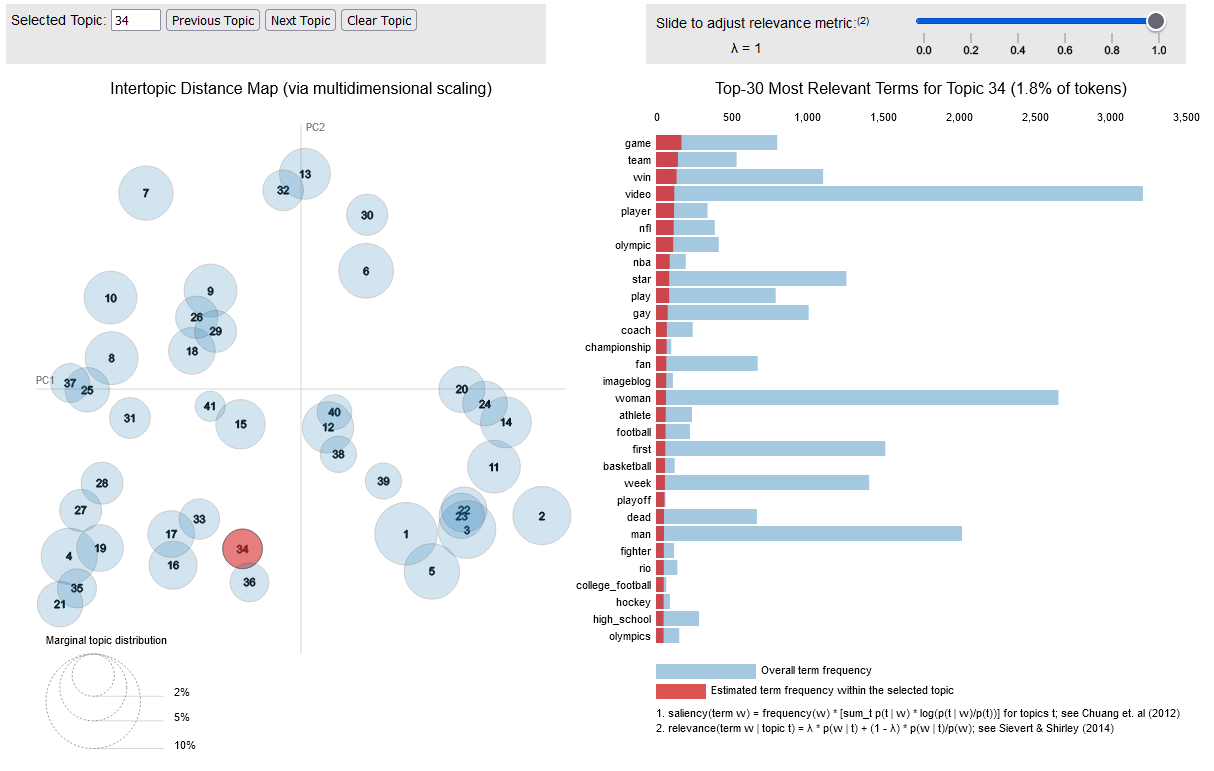

## HDP Training

This type provides Hierarchical Dirichlet Process(HDP) topic model and its implementation is based on following papers:

        Teh, Y. W., Jordan, M. I., Beal, M. J., & Blei, D. M. (2005). Sharing clusters among related groups: Hierarchical Dirichlet processes. In Advances in neural information processing systems (pp. 1385-1392).
        Newman, D., Asuncion, A., Smyth, P., & Welling, M. (2009). Distributed algorithms for topic models. Journal of Machine Learning Research, 10(Aug), 1801-1828.

<br> Ce modèle HDP est un dérivé de la LDA, mais il est non paramètrique. 
<br> Avec ce modèle, il peut trouver lui meme le nombre optimale de topic.
<br> Cepndant, étant donné que nous avons un dataset mal équilibré, cela va se répercuter sur les topic générés. 
<br>

In [31]:
term_weight = tp.TermWeight.IDF
#term_weight = tp.TermWeight.ONE

# alpha : concentration coeficient of Dirichlet Process for document-table
# gamma : concentration coeficient of Dirichlet Process for table-topic

hdp = tp.HDPModel(tw=term_weight, min_cf=5, rm_top=3, gamma=1, alpha=0.1, initial_k=5, seed=99999)

#for vec in tqdm(l_texts):
for vec in sa_l_texts:
    if vec: 
        hdp.add_doc(vec)
        
        
# Initiate sampling burn-in  (i.e. discard 100 first iterations)
hdp.burn_in = 100
hdp.train(0)
print('Num docs:', len(hdp.docs), ', Vocab size:', hdp.num_vocabs,
      ', Num words:', hdp.num_words)
print('Removed top words:', hdp.removed_top_words)    

Num docs: 200699 , Vocab size: 17459 , Num words: 1077817
Removed top words: ['photo', 'new', 'make']


In [32]:
# Train model
for i in tqdm(range(0, 1000, 100)):
    hdp.train(100) # 100 iterations at a time
    print('Iteration: {}\tLog-likelihood: {}\tNum. of topics: {}'.format(i, hdp.ll_per_word, hdp.live_k))

 10%|█         | 1/10 [00:22<03:26, 22.91s/it]

Iteration: 0	Log-likelihood: -8.158551442961166	Num. of topics: 350


 30%|███       | 3/10 [02:51<07:26, 63.78s/it]

Iteration: 100	Log-likelihood: -7.993809930126949	Num. of topics: 923
Iteration: 200	Log-likelihood: -7.897743560158532	Num. of topics: 1152


 60%|██████    | 6/10 [07:22<05:37, 84.30s/it]

Iteration: 300	Log-likelihood: -7.846082307652161	Num. of topics: 1278
Iteration: 400	Log-likelihood: -7.810941514642516	Num. of topics: 1320
Iteration: 500	Log-likelihood: -7.782600313117371	Num. of topics: 1393


 70%|███████   | 7/10 [09:08<04:34, 91.49s/it]

Iteration: 600	Log-likelihood: -7.762352032854211	Num. of topics: 1416


 90%|█████████ | 9/10 [12:41<01:39, 99.39s/it]

Iteration: 700	Log-likelihood: -7.746625942138269	Num. of topics: 1470
Iteration: 800	Log-likelihood: -7.732015347885524	Num. of topics: 1506


100%|██████████| 10/10 [14:26<00:00, 86.64s/it] 

Iteration: 900	Log-likelihood: -7.720690943707392	Num. of topics: 1517


In [33]:
def get_hdp_topics(hdp, top_n):
    '''Wrapper function to extract topics from trained tomotopy HDP model 
    
    ** Inputs **
    hdp:obj -> HDPModel trained model
    top_n: int -> top n words in topic based on frequencies
    
    ** Returns **
    topics: dict -> per topic, an arrays with top words and associated frequencies 
    '''
    
    # Get most important topics by # of times they were assigned (i.e. counts)
    sorted_topics = [k for k, v in sorted(enumerate(hdp.get_count_by_topics()), key=lambda x:x[1], reverse=True)]

    topics=dict()
    
    # For topics found, extract only those that are still assigned
    for k in sorted_topics:
        if not hdp.is_live_topic(k): continue # remove un-assigned topics at the end (i.e. not alive)
        topic_wp =[]
        for word, prob in hdp.get_topic_words(k, top_n=top_n):
            topic_wp.append((word, prob))

        topics[k] = topic_wp # store topic word/frequency array
        
    return topics

In [34]:
topics_HDP = get_hdp_topics(hdp, top_n=5) # changing top_n changes no. of words displayed

In [35]:
k = 543
print("source : " + str(source[k]))

source : Angry White Dude's Rant About People Speaking Spanish In NYC Goes Viral


In [36]:
len(topics_HDP)

1517

In [37]:
topics_HDP[0]

[('look', 0.006984621286392212),
 ('wear', 0.006367578636854887),
 ('style', 0.006030261516571045),
 ('dress', 0.0058192177675664425),
 ('fashion', 0.00498341117054224)]

In [38]:
#hdp.save('sample_hdp_model.bin')
# Iteration: 900	Log-likelihood: -7.124920004899671	Num. of topics: 2002

In [39]:
#hdp = tp.HDPModel.load('sample_hdp_model.bin')

### Cohérence et Inférence


In [40]:
# Build gensim objects

vocab = corpora.Dictionary(sa_l_texts)
corpus = [vocab.doc2bow(words) for words in sa_l_texts]

# Build topic list from dictionary
topic_list=[]
for k, tups in topics_HDP.items():
    topic_tokens=[]
    for w, p in tups:
        topic_tokens.append(w)

    topic_list.append(topic_tokens)

In [41]:
cm = CoherenceModel(topics=topic_list, corpus=corpus, dictionary=vocab,
                    texts=sa_l_texts, coherence='c_v')
    
cm.get_coherence()

0.6278794485301327

### Résultats Matrice de Cohérence
En test sur une échantillon de 5000 headlind, nous avons pu monter à un taut de 0.66 env.
Cependant, en vérifiant certains headline avec le topic associé manuellement, on se rend compte que les résultats n'étaient pas sattisfaisant.
Apres d'autres essaie avec 100k headlines, nous avons un taut de 0.66 et les topics nous semblent plus logique que les résultats précédents.

En utilisant la totalité des headlines (200k) nous avons un taut à 0.52. En vérifiant manuellement les résultats sont plus logiques.

Ont aurraient put continuer à faire du fine tunning. Mais l'entrainnement avec 200k prennais 15-20 min/entrainnement.

In [42]:
#sarcasme ligne = 6208
ligne = 6208
#ligne = 65923


test_doc = sa_l_texts[ligne]
doc_inst = hdp.make_doc(test_doc)
topic_dist, ll = hdp.infer(doc_inst)
topic_idx = np.array(topic_dist).argmax()

print("Id du topic ligne {} :\t {}".format(ligne, topic_idx))
print("\nHeadline : " + source[ligne])
print("Lematisation : " + str(sa_l_texts[ligne]))

Id du topic ligne 6208 :	 4

Headline : Kevin Hart Drops An F-Bomb In Awkward NFL Network Interview
Lematisation : ['kevin_hart', 'drop', 'bomb', 'awkward', 'nfl', 'network', 'interview']


In [43]:
hdp.get_topic_words(topic_idx)

[('video', 0.004989827983081341),
 ('star', 0.003134380094707012),
 ('watch', 0.002855478087440133),
 ('get', 0.0028133795130997896),
 ('show', 0.002685556886717677),
 ('say', 0.0026424441020935774),
 ('woman', 0.0025317531544715166),
 ('movie', 0.0023147014435380697),
 ('love', 0.002166733844205737),
 ('first', 0.002146131591871381)]

In [44]:
print(dataset.loc[ligne,["category","headline","short_description"]])
print('\n' + dataset["link"][ligne])

category                                                        COMEDY
headline             Kevin Hart Drops An F-Bomb In Awkward NFL Netw...
short_description                                "I've been drinking."
Name: 6208, dtype: object

https://www.huffingtonpost.com/entry/kevin-hart-nfl-f-bomb_us_5a7816f2e4b06ee97af49a0f


### Visualisation

In [45]:
# en cherchant à debud l'affichage via pyLDAvis
# https://github.com/bab2min/tomotopy/issues/74
#Avec tomotopy, il faut convertir 

ldamodel, _ = hdp.convert_to_lda(topic_threshold=0.001)

# pyLDAvis에 입력하여 시각화하기
topic_term_dists = np.stack([ldamodel.get_topic_word_dist(k) for k in range(ldamodel.k)])
doc_topic_dists = np.stack([doc.get_topic_dist() for doc in ldamodel.docs])
doc_lengths = np.array([len(doc.words) for doc in ldamodel.docs])
vocab = list(ldamodel.used_vocabs)
term_frequency = ldamodel.used_vocab_freq

prepared_data = pyLDAvis.prepare(
    topic_term_dists, 
    doc_topic_dists, 
    doc_lengths, 
    vocab, 
    term_frequency
)
pyLDAvis.save_html(prepared_data, 'ldavisModelHDP.html')

### Analyse de HDP
On remarque que nous avons beaucoup de Topic (varie entre 1400 et 1500). 
Or les 6 premiers sont plus volumineux que les autres.

Cela est du au dataset, car il n'est pas équilibré. En effet les Catégories du dataset sont très orienté politique, bien etre et divertissement.

Notre modèle HDP nous a bien montré ce déséquilibre. cependant, il a trouvé des sous catégories, qui est expliqué par une superposition des topic (exemple Topic 2 et 4 dans ldavisModelHDP.html)

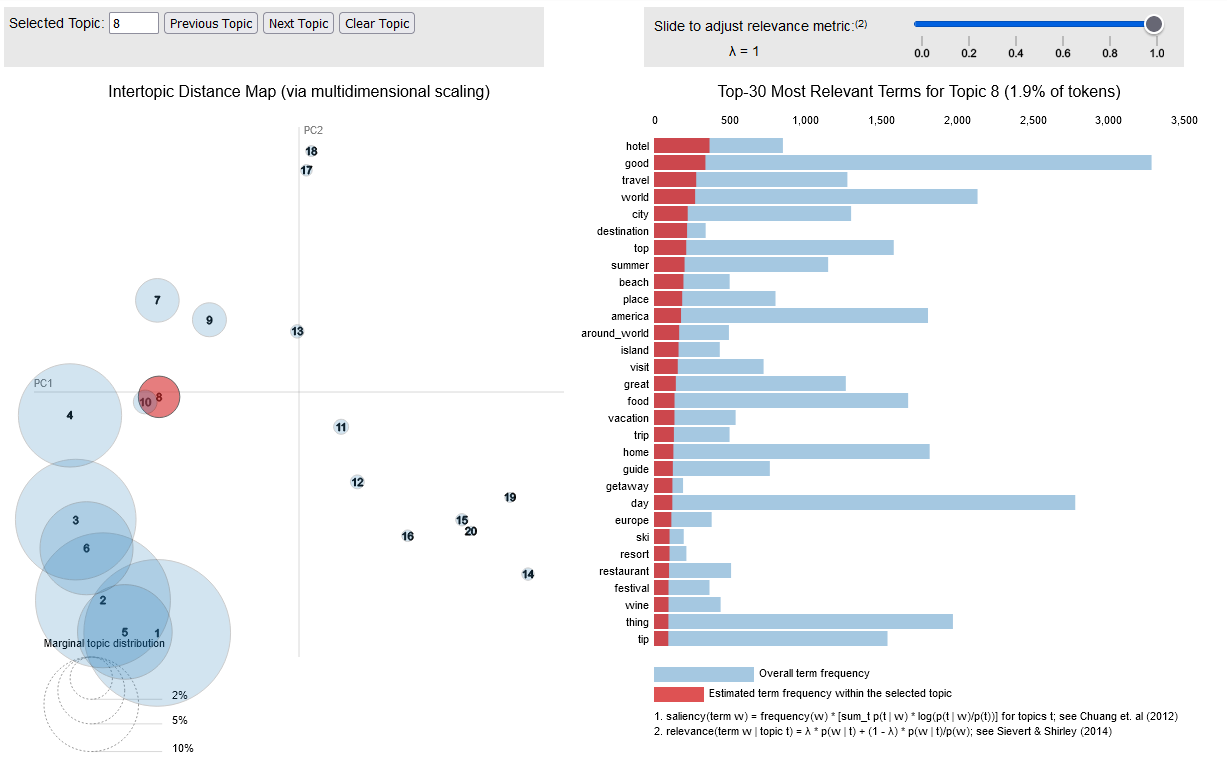


In [46]:
eq = dataset['category'].value_counts()
eq[:6]

POLITICS          32739
WELLNESS          17827
ENTERTAINMENT     16058
TRAVEL             9887
STYLE & BEAUTY     9649
PARENTING          8677
Name: category, dtype: int64

## DMR Training
This type provides Dirichlet Multinomial Regression(DMR) topic model and its implementation is based on following papers:

        Mimno, D., & McCallum, A. (2012). Topic models conditioned on arbitrary features with dirichlet-multinomial regression. arXiv preprint arXiv:1206.3278.

<br>Ici nous avons voulu tester un modèle qui utilise la régression multinomial, car il semblait adapté à notre cas.
<br>

In [47]:
term_weight = tp.TermWeight.IDF
#term_weight = tp.TermWeight.ONE

pkm = tp.DMRModel(tw=term_weight, min_cf=5, rm_top=0, k=41, alpha=0.1, eta=0.01, sigma=1.0, alpha_epsilon=1e-10, seed=99999)

#for vec in tqdm(l_texts):
for vec in sa_l_texts:
    if vec: 
        pkm.add_doc(vec)
        
        
# Initiate sampling burn-in  (i.e. discard 100 first iterations)
pkm.burn_in = 100
pkm.train(0)
print('Num docs:', len(pkm.docs), ', Vocab size:', pkm.num_vocabs,
      ', Num words:', pkm.num_words)
print('Removed top words:', pkm.removed_top_words)    

Num docs: 200699 , Vocab size: 17462 , Num words: 1101470
Removed top words: []


In [48]:
# Train model
for i in tqdm(range(0, 1000, 100)):
    pkm.train(100) # 100 iterations at a time
    print('Iteration: {}\tLog-likelihood: {}\tNum. of topics: {}'.format(i, pkm.ll_per_word, 41))

 10%|█         | 1/10 [00:08<01:14,  8.23s/it]

Iteration: 0	Log-likelihood: -8.089072898641728	Num. of topics: 41


 30%|███       | 3/10 [02:39<07:00, 60.06s/it]

Iteration: 100	Log-likelihood: -7.818005485232439	Num. of topics: 41
Iteration: 200	Log-likelihood: -7.805404750389688	Num. of topics: 41


 60%|██████    | 6/10 [06:20<04:44, 71.23s/it]

Iteration: 300	Log-likelihood: -7.796184216130757	Num. of topics: 41
Iteration: 400	Log-likelihood: -7.789498982172694	Num. of topics: 41
Iteration: 500	Log-likelihood: -7.784845761883461	Num. of topics: 41


 70%|███████   | 7/10 [07:38<03:40, 73.58s/it]

Iteration: 600	Log-likelihood: -7.780246602200492	Num. of topics: 41


 90%|█████████ | 9/10 [10:16<01:16, 76.83s/it]

Iteration: 700	Log-likelihood: -7.775689345697015	Num. of topics: 41
Iteration: 800	Log-likelihood: -7.772773404420799	Num. of topics: 41


100%|██████████| 10/10 [11:29<00:00, 68.95s/it]

Iteration: 900	Log-likelihood: -7.768671111801999	Num. of topics: 41


In [49]:
def get_pkm_topics(model, top_n):
    
    # Get most important topics by # of times they were assigned (i.e. counts)
    sorted_topics = [k for k, v in sorted(enumerate(model.get_count_by_topics()), key=lambda x:x[1], reverse=True)]

    topics=dict()
    
    # For topics found, extract only those that are still assigned
    for k in sorted_topics:
        topic_wp =[]
        for word, prob in model.get_topic_words(k, top_n=top_n):
            topic_wp.append((word, prob))

        topics[k] = topic_wp # store topic word/frequency array
        
    return topics

In [50]:
topicsPKM = get_pkm_topics(pkm, top_n=10)

In [51]:
len(topicsPKM)

41

In [52]:
topicsPKM[0]

[('say', 0.00532010430470109),
 ('woman', 0.005086919758468866),
 ('gay', 0.004664306063205004),
 ('donald', 0.004145192448049784),
 ('pope', 0.003776837605983019),
 ('man', 0.003392093116417527),
 ('call', 0.0033753712195903063),
 ('pope_francis', 0.0033329881262034178),
 ('cheat', 0.00327825965359807),
 ('victim', 0.0028011843096464872)]

In [53]:
# Build gensim objects
vocab = corpora.Dictionary(sa_l_texts)
corpus = [vocab.doc2bow(words) for words in sa_l_texts]

# Build topic list from dictionary
topic_list=[]
for k, tups in topicsPKM.items():
    topic_tokens=[]
    for w, p in tups:
        topic_tokens.append(w)

    topic_list.append(topic_tokens)

In [54]:
cm = CoherenceModel(topics=topic_list, corpus=corpus, dictionary=vocab,
                    texts=sa_l_texts, coherence='c_v')
    
cm.get_coherence()

0.36499875200086623

In [55]:
model = pkm

topic_term_dists = np.stack([model.get_topic_word_dist(k) for k in range(model.k)])
doc_topic_dists = np.stack([doc.get_topic_dist() for doc in model.docs])
doc_lengths = np.array([len(doc.words) for doc in model.docs])
vocab = list(model.used_vocabs)
term_frequency = model.used_vocab_freq

prepared_data = pyLDAvis.prepare(
    topic_term_dists, 
    doc_topic_dists, 
    doc_lengths, 
    vocab, 
    term_frequency
)
pyLDAvis.save_html(prepared_data, 'ldavisModelDMR_IDF.html')

In [56]:
#topic_term_dists.shape

In [57]:
#doc_topic_dists.shape

### Analyse de DMR

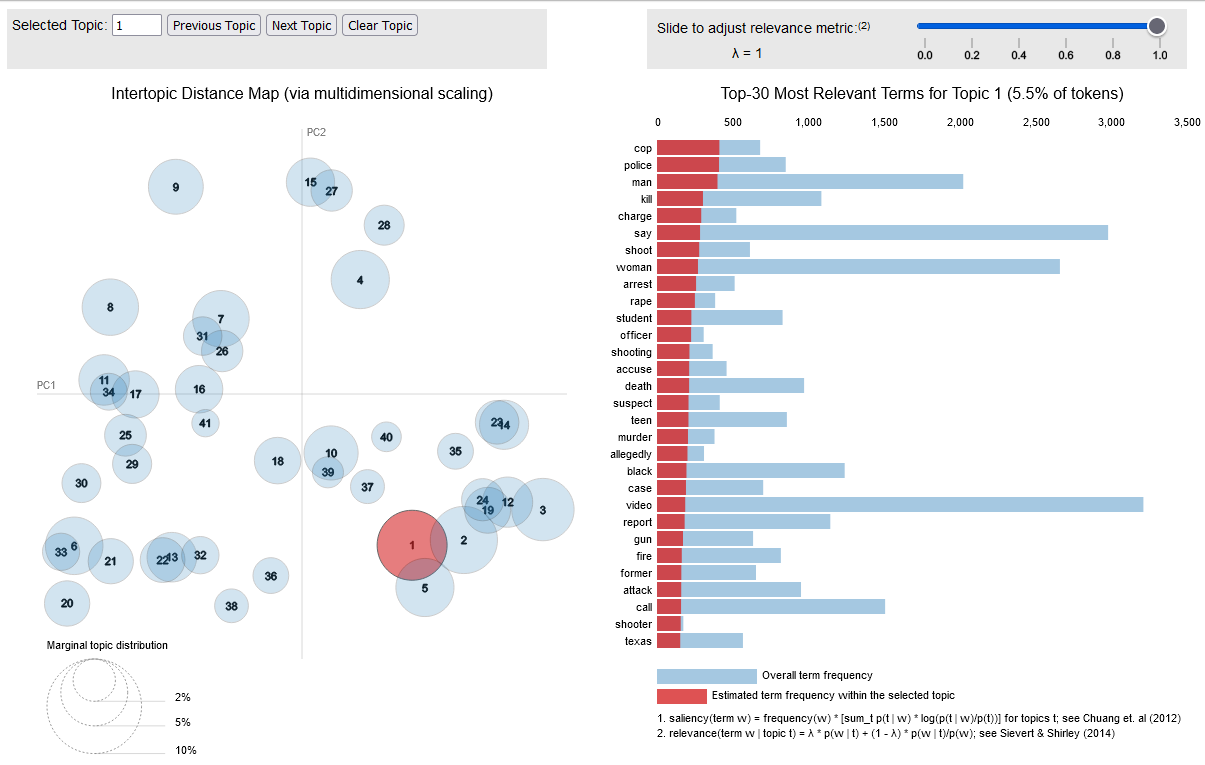

## BERT

Nous avons voulu tester un 4eme Modèle avec BERT, afin comparer avec nos résultats précédents. 


In [58]:
dataset = pd.read_json("News_Category_Dataset_v2.json", lines=True, dtype={"headline": str})
headlines = dataset.headline.to_list()

In [ ]:
#model = BERTopic(verbose=True)
model = BERTopic(nr_topics=41, verbose=True) 

topics, probabilities = model.fit_transform(headlines)

Batches:   0%|          | 0/6277 [00:00<?, ?it/s]

In [ ]:
html = model.visualize_topics()
html.write_html("BertModel41.html")

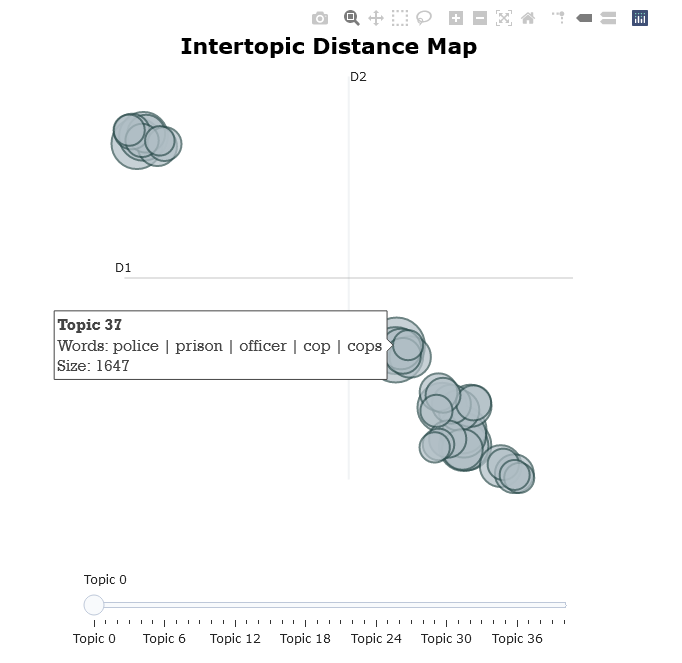

In [ ]:
barChart = model.visualize_barchart()
model.visualize_barchart()

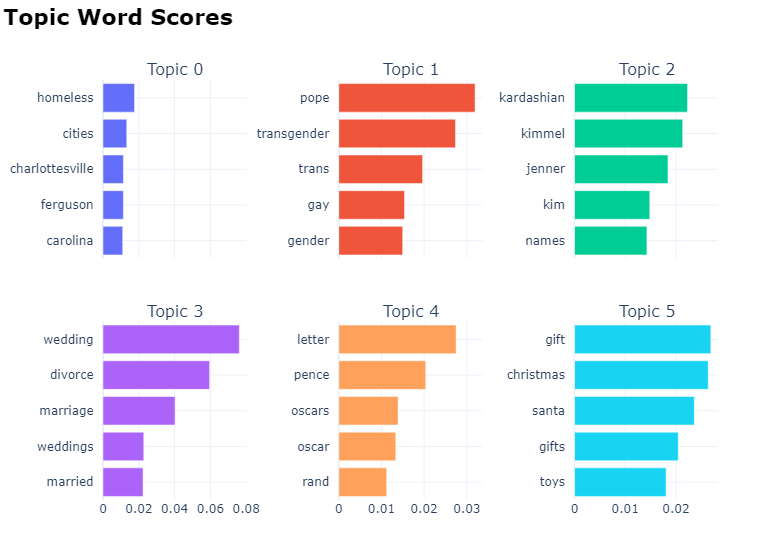

## Analyse Bert

<br>Avec BERT, nous avons du spécifier le nombre de topic que nous souhaitions. 
<br>Sans spécifier le nombre de topics, nous n'avions pas de résultats cohérents avec nos précédentes méthodes.
<br>Apres quelque itérations, nous avons obtenur un résultats semblable au HDP réalisé précédement, mais les topics ont plus d'overlap.
<br>Nous n'avons pas fait de pré preocessing avec le modèle BERT, mais il serait interessant d'en faire une pour voir les résultats.

## ANNEXE

Nous avons tenté d'implémenter CBOW, cependant nous nous somme rendu compte plus tard que c'était une 2eme méthode d'embeding.
<br>Nous avons donc repris à partir du TP 2


In [ ]:
# Create CBOW model

model_cbow = gensim.models.Word2Vec(l_texts, window = 4)
# Print results
print("Cosine similarity between 'trump' " + 
               "and 'weapon' - CBOW : ",
    model_cbow.wv.similarity('trump', 'weapon'))
      
print("Cosine similarity between 'trump' " +
                 "and 'war' - CBOW : ",
      model_cbow.wv.similarity('trump', 'war'))

# Create Skip Gram model
model_skipgram = gensim.models.Word2Vec(l_texts, window = 4, sg = 1)
# Print results
print("Cosine similarity between 'trump' " + 
               "and 'weapon' - Skip Gram : ",
    model_skipgram.wv.similarity('trump', 'weapon'))
      
print("Cosine similarity between 'trump' " +
                 "and 'war' - Skip Gram : ",
      model_skipgram.wv.similarity('trump', 'war'))

In [ ]:
model_cbow.wv.most_similar("trump")

In [ ]:
dbscan = DBSCAN(metric='cosine', eps=0.07, min_samples=3)
cluster_labels = dbscan.fit_predict(X)

In [ ]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []
    
    for word in model.wv.key_to_index:
        
        tokens.append(model.wv[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(50, 50)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.savefig("output.png")
    plt.show()

In [ ]:
tsne_plot(model_cbow)